<a href="https://colab.research.google.com/github/ritusinha128/health-informatics-project/blob/main/skin_cancer/Melanoma_Data_Analysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connecting to Kaggle to access dataset:


In [1]:
'''
Steps to generate kaggle.json:
1. Go to your Kaggle account settings
2. Scroll down to the API section and click on "Create New API Token".
3. This will download a kaggle.json file containing your API credentials.
'''

#Upload kaggle.json file here - to directly connect to dataset on Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ritu1208","key":"d92b6ede9ffc0570b55ab5ffbe50474f"}'}

In [2]:
#Set up the kaggle API

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#download melanoma dataset - (https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images?resource=download)

!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 98% 97.0M/98.7M [00:06<00:00, 21.4MB/s]
100% 98.7M/98.7M [00:06<00:00, 14.8MB/s]


In [ ]:
!unzip /content/melanoma-skin-cancer-dataset-of-10000-images.zip

## Import Required Libraries

In [5]:
import numpy as np
import pandas as pd
import os

from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

## Data Preprocessing and loading

In [6]:
transform = transforms.Compose([transforms.Resize((227, 227)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64

train_set = torchvision.datasets.ImageFolder('melanoma_cancer_dataset/train',
                                            transform=transform)

test_set = torchvision.datasets.ImageFolder('melanoma_cancer_dataset/test',
                                            transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = train_set.classes

classes

['benign', 'malignant']

In [ ]:
# Function to show an image
def imshow(img, labels, classes):
    # Unnormalize
    img = img / 2 + 0.5
    # Convert from tensor image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # Adding the labels
    for i, label in enumerate(labels):
        plt.text(0, i*15, f'{classes[label]}', color='white', fontsize=8, ha='left', va='top')

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Make a grid from batch and show it with labels
out = torchvision.utils.make_grid(images)
imshow(out, labels, train_set.classes)



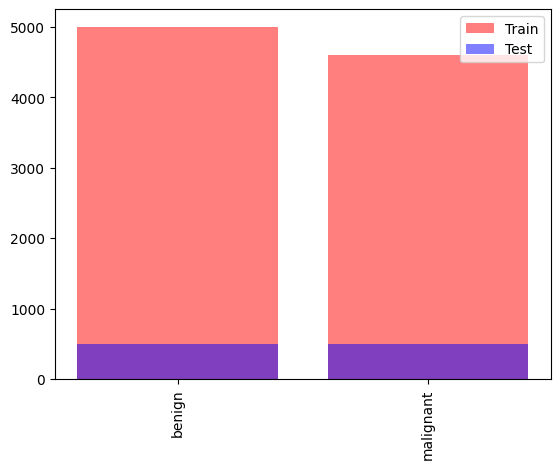

In [8]:
from collections import Counter

# Counting the number of instances per class in the train set
train_counts = Counter([label for _, label in train_set.imgs])
test_counts = Counter([label for _, label in test_set.imgs])

# Plotting the distribution
plt.bar(train_counts.keys(), train_counts.values(), color='r', alpha=0.5, label='Train')
plt.bar(test_counts.keys(), test_counts.values(), color='b', alpha=0.5, label='Test')
plt.xticks(ticks=list(train_counts.keys()), labels=[classes[i] for i in train_counts.keys()], rotation='vertical')
plt.legend()
plt.show()


## Instantiate CNN - AlexNet

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
'''
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.AdaptiveAvgPool2d((6, 6))
                                     )

        self.classifier = nn.Sequential(nn.Linear(256 * 6 * 6, 4096),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(4096, 4096),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(4096, 2)
                                       )


    def forward(self, x):
        x = self.features(x)

        x = x.view(-1, 6 * 6 * 256)

        x = self.classifier(x)
        return x


model = AlexNet()
model.to(device)
'''
import torchvision.models as models

pretrained_alexnet = models.alexnet(pretrained=True)

num_ftrs = pretrained_alexnet.classifier[6].in_features
pretrained_alexnet.classifier[6] = nn.Linear(num_ftrs, 2)

for param in pretrained_alexnet.features.parameters():
    param.requires_grad = False

pretrained_alexnet = pretrained_alexnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 95.2MB/s]


In [10]:
#loss function
criterion = nn.CrossEntropyLoss()

## K Fold Cross Validation

In [11]:
torch.manual_seed(42)

#dataset = ConcatDataset([train_set, test_set])
dataset = train_set

num_epochs = 30

k = 5

splits = KFold(n_splits = k, shuffle = True, random_state = 42)

foldperf = {}

In [12]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss, train_correct

def valid_epoch(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_fn(output,labels)
        valid_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()

    return valid_loss, val_correct

## Access to Drive to save model

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Train Model

In [14]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
    test_loader = DataLoader(dataset, batch_size = batch_size, sampler = test_sampler)

    optimizer = optim.SGD(pretrained_alexnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in tqdm(range(num_epochs)):
        train_loss, train_correct=train_epoch(pretrained_alexnet, device, train_loader, criterion, optimizer)
        test_loss, test_correct=valid_epoch(pretrained_alexnet, device, test_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} || AVG Training Loss:{:.3f} || AVG Test Loss:{:.3f} || AVG Training Acc {:.2f} % || AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history

torch.save(pretrained_alexnet,'/content/drive/My Drive/Health_Informatics_Project/melanoma_CNN.pt')

Fold 1


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:1/30 || AVG Training Loss:0.299 || AVG Test Loss:0.240 || AVG Training Acc 87.62 % || AVG Test Acc 90.89 %
Epoch:2/30 || AVG Training Loss:0.241 || AVG Test Loss:0.220 || AVG Training Acc 90.34 % || AVG Test Acc 91.05 %
Epoch:3/30 || AVG Training Loss:0.237 || AVG Test Loss:0.203 || AVG Training Acc 90.73 % || AVG Test Acc 91.67 %
Epoch:4/30 || AVG Training Loss:0.198 || AVG Test Loss:0.206 || AVG Training Acc 92.05 % || AVG Test Acc 91.72 %
Epoch:5/30 || AVG Training Loss:0.190 || AVG Test Loss:0.194 || AVG Training Acc 92.75 % || AVG Test Acc 92.19 %
Epoch:6/30 || AVG Training Loss:0.181 || AVG Test Loss:0.188 || AVG Training Acc 92.76 % || AVG Test Acc 92.66 %
Epoch:7/30 || AVG Training Loss:0.173 || AVG Test Loss:0.187 || AVG Training Acc 93.49 % || AVG Test Acc 92.56 %
Epoch:8/30 || AVG Training Loss:0.169 || AVG Test Loss:0.190 || AVG Training Acc 93.43 % || AVG Test Acc 92.66 %
Epoch:9/30 || AVG Training Loss:0.162 || AVG Test Loss:0.184 || AVG Training Acc 93.57 % || AVG 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:1/30 || AVG Training Loss:0.116 || AVG Test Loss:0.037 || AVG Training Acc 95.74 % || AVG Test Acc 98.96 %
Epoch:2/30 || AVG Training Loss:0.110 || AVG Test Loss:0.040 || AVG Training Acc 95.91 % || AVG Test Acc 99.01 %
Epoch:3/30 || AVG Training Loss:0.107 || AVG Test Loss:0.041 || AVG Training Acc 96.00 % || AVG Test Acc 98.70 %
Epoch:4/30 || AVG Training Loss:0.102 || AVG Test Loss:0.045 || AVG Training Acc 96.28 % || AVG Test Acc 98.59 %
Epoch:5/30 || AVG Training Loss:0.097 || AVG Test Loss:0.045 || AVG Training Acc 96.32 % || AVG Test Acc 98.65 %
Epoch:6/30 || AVG Training Loss:0.091 || AVG Test Loss:0.047 || AVG Training Acc 96.80 % || AVG Test Acc 98.18 %
Epoch:7/30 || AVG Training Loss:0.082 || AVG Test Loss:0.045 || AVG Training Acc 96.92 % || AVG Test Acc 98.49 %
Epoch:8/30 || AVG Training Loss:0.084 || AVG Test Loss:0.048 || AVG Training Acc 96.93 % || AVG Test Acc 98.44 %
Epoch:9/30 || AVG Training Loss:0.078 || AVG Test Loss:0.047 || AVG Training Acc 97.25 % || AVG 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:1/30 || AVG Training Loss:0.058 || AVG Test Loss:0.010 || AVG Training Acc 98.06 % || AVG Test Acc 100.00 %
Epoch:2/30 || AVG Training Loss:0.071 || AVG Test Loss:0.011 || AVG Training Acc 97.38 % || AVG Test Acc 99.90 %
Epoch:3/30 || AVG Training Loss:0.054 || AVG Test Loss:0.012 || AVG Training Acc 98.14 % || AVG Test Acc 99.90 %
Epoch:4/30 || AVG Training Loss:0.055 || AVG Test Loss:0.012 || AVG Training Acc 97.93 % || AVG Test Acc 99.79 %
Epoch:5/30 || AVG Training Loss:0.048 || AVG Test Loss:0.011 || AVG Training Acc 98.23 % || AVG Test Acc 99.95 %
Epoch:6/30 || AVG Training Loss:0.045 || AVG Test Loss:0.011 || AVG Training Acc 98.57 % || AVG Test Acc 99.84 %
Epoch:7/30 || AVG Training Loss:0.045 || AVG Test Loss:0.013 || AVG Training Acc 98.39 % || AVG Test Acc 99.84 %
Epoch:8/30 || AVG Training Loss:0.041 || AVG Test Loss:0.011 || AVG Training Acc 98.65 % || AVG Test Acc 99.84 %
Epoch:9/30 || AVG Training Loss:0.051 || AVG Test Loss:0.013 || AVG Training Acc 97.98 % || AVG

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:1/30 || AVG Training Loss:0.030 || AVG Test Loss:0.004 || AVG Training Acc 99.04 % || AVG Test Acc 99.95 %
Epoch:2/30 || AVG Training Loss:0.031 || AVG Test Loss:0.005 || AVG Training Acc 98.97 % || AVG Test Acc 99.95 %
Epoch:3/30 || AVG Training Loss:0.028 || AVG Test Loss:0.006 || AVG Training Acc 99.09 % || AVG Test Acc 99.90 %
Epoch:4/30 || AVG Training Loss:0.028 || AVG Test Loss:0.005 || AVG Training Acc 99.17 % || AVG Test Acc 99.95 %
Epoch:5/30 || AVG Training Loss:0.029 || AVG Test Loss:0.006 || AVG Training Acc 98.89 % || AVG Test Acc 99.95 %
Epoch:6/30 || AVG Training Loss:0.030 || AVG Test Loss:0.005 || AVG Training Acc 99.04 % || AVG Test Acc 99.95 %
Epoch:7/30 || AVG Training Loss:0.025 || AVG Test Loss:0.007 || AVG Training Acc 99.23 % || AVG Test Acc 99.84 %
Epoch:8/30 || AVG Training Loss:0.027 || AVG Test Loss:0.007 || AVG Training Acc 99.14 % || AVG Test Acc 99.90 %
Epoch:9/30 || AVG Training Loss:0.024 || AVG Test Loss:0.007 || AVG Training Acc 99.38 % || AVG 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:1/30 || AVG Training Loss:0.022 || AVG Test Loss:0.002 || AVG Training Acc 99.32 % || AVG Test Acc 100.00 %
Epoch:2/30 || AVG Training Loss:0.022 || AVG Test Loss:0.001 || AVG Training Acc 99.21 % || AVG Test Acc 100.00 %
Epoch:3/30 || AVG Training Loss:0.020 || AVG Test Loss:0.002 || AVG Training Acc 99.38 % || AVG Test Acc 100.00 %
Epoch:4/30 || AVG Training Loss:0.018 || AVG Test Loss:0.002 || AVG Training Acc 99.49 % || AVG Test Acc 100.00 %
Epoch:5/30 || AVG Training Loss:0.018 || AVG Test Loss:0.002 || AVG Training Acc 99.45 % || AVG Test Acc 100.00 %
Epoch:6/30 || AVG Training Loss:0.024 || AVG Test Loss:0.002 || AVG Training Acc 99.25 % || AVG Test Acc 100.00 %
Epoch:7/30 || AVG Training Loss:0.018 || AVG Test Loss:0.002 || AVG Training Acc 99.58 % || AVG Test Acc 100.00 %
Epoch:8/30 || AVG Training Loss:0.018 || AVG Test Loss:0.002 || AVG Training Acc 99.49 % || AVG Test Acc 100.00 %
Epoch:9/30 || AVG Training Loss:0.018 || AVG Test Loss:0.002 || AVG Training Acc 99.43 %

In [16]:
nb_classes = 2

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    test_running_corrects = 0.0
    test_total = 0.0
    pretrained_alexnet.eval()
    for i, (test_inputs, test_labels) in enumerate(test_loader, 0):
        test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()

        test_outputs = pretrained_alexnet(test_inputs)
        _, test_outputs = torch.max(test_outputs, 1)

        test_total += test_labels.size(0)
        test_running_corrects += (test_outputs == test_labels).sum().item()

        for t, p in zip(test_labels.view(-1), test_outputs.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1


    print(f'Testing Accuracy: {(100 * test_running_corrects / test_total)}%')
print(f'Confusion Matrix:\n {confusion_matrix}')

Testing Accuracy: 92.5%
Confusion Matrix:
 tensor([[476.,  24.],
        [ 51., 449.]])


In [17]:
precision = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
recall = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])

f1_score = 2 * precision * recall / (precision + recall)
print(f'F1 Score: {f1_score: .3f}')

F1 Score:  0.927
